In [1]:
import sys
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))

from utils.watertopo import WaterTopo
from utils.simulation import Simulation
from utils.utils import count_parameters

In [3]:
from models.CNNPIDPID import BasicCNN_PINN, create_sequence, train_and_validate, evaluate_model, train, punish_false_dry

In [4]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? True
Number of GPUs 1


In [10]:
model_PID = BasicCNN_PINN(input_channels=2,
                 hidden_size=64,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu,
                 max_dV=0.5*3600*50
                 ).to(device)

print(f"CNN --> num. trainable parameters:{count_parameters(model_PID):8d}")

CNN --> num. trainable parameters:  112577


In [13]:
model_PID, train_losses, val_losses, best_val_loss, train_time = train(model_PID,
                                                 device=device,
                                                 root=root,
                                                 model_name = 'CNN/CNN_PID',
                                                 channels=2,
                                                 T=1,
                                                 H=1,
                                                 sim_amount=400,
                                                 training_size=0.8,
                                                 use_augmented_data=True,
                                                 batch_size=10,
                                                 num_epochs=100,
                                                 lr=0.005,
                                                 criterion=nn.MSELoss(),
                                                 optimizer=optim.AdamW,
                                                 )

shape of X:  (38000, 2, 64, 64)
shape of Y:  (38000, 1, 64, 64)
starting training


KeyboardInterrupt: 

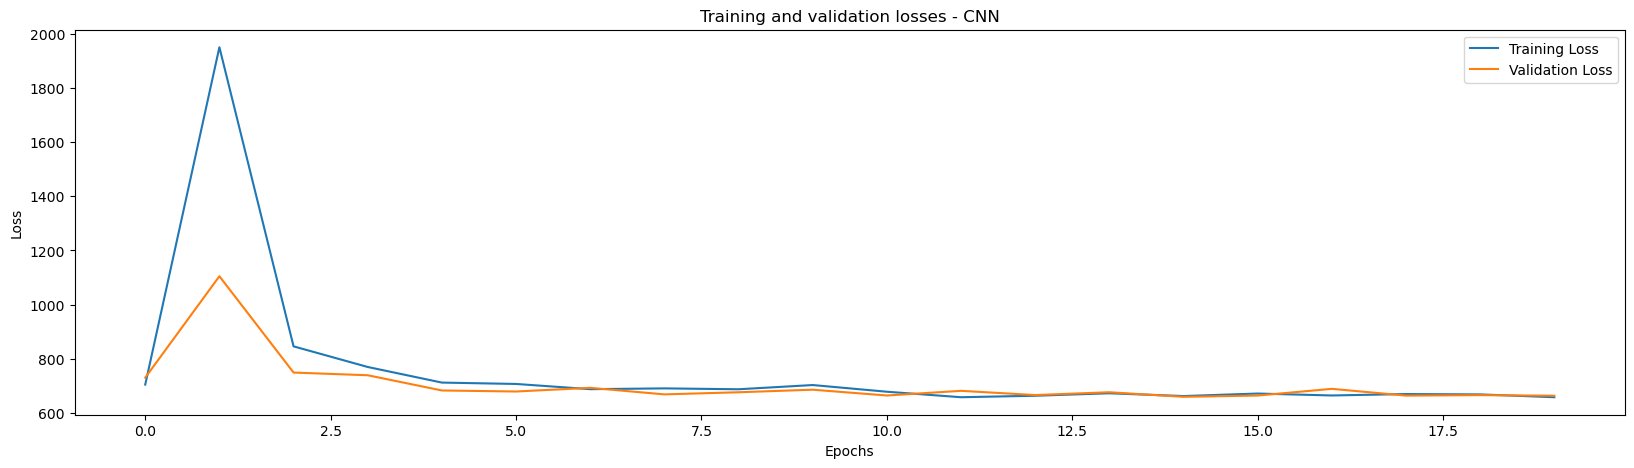

In [ ]:
# Plot validation loss
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and validation losses - CNN')
ax.legend()

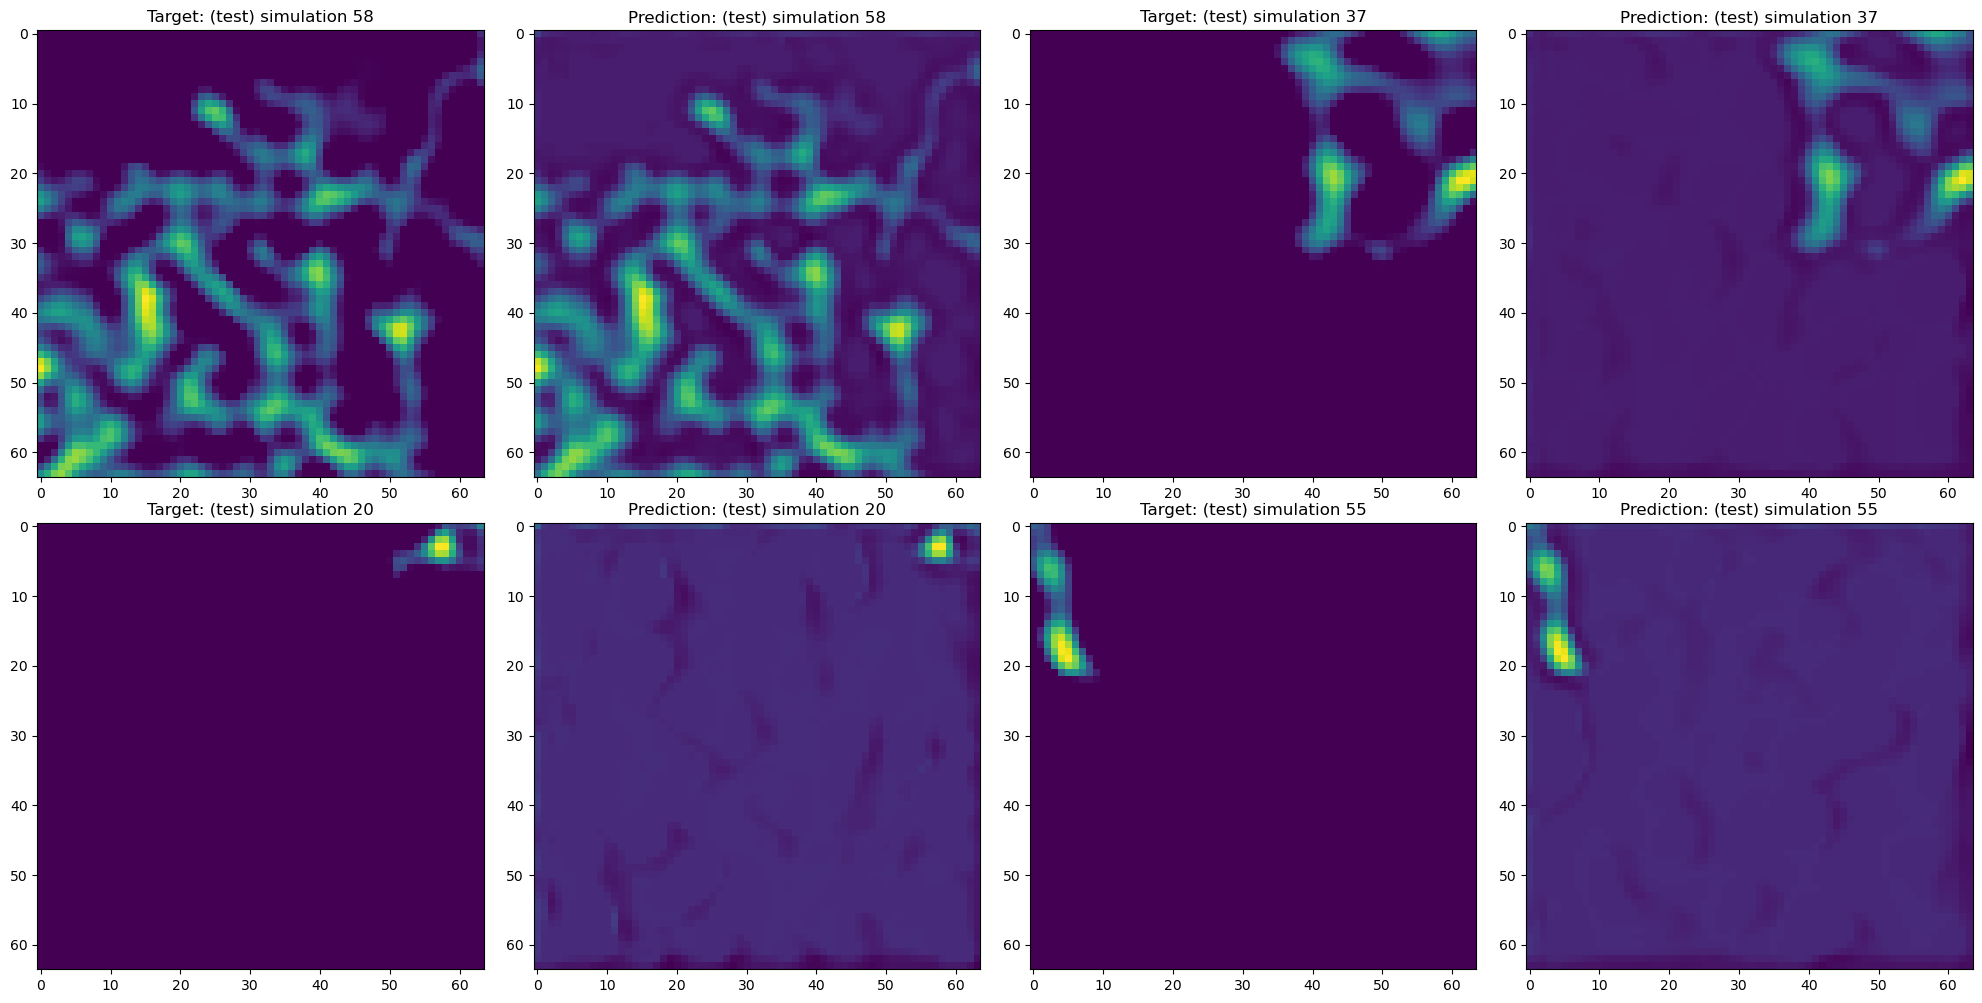

In [ ]:
# Let's try the model!
model_PID.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      random_index = random.randint(0, 80)
      sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 
                                       1, 
                                       grid_size)[0]

      inputs = np.zeros((1, channels, grid_size, grid_size))
      targets = np.zeros((1, grid_size, grid_size))

      id = random.randint(0, 95)

      inputs[0, 0,:,:] = sim.topography
      inputs[0, 1,:,:] = sim.return_timestep(id)
      targets[0, :,:]  = sim.return_timestep(id+1)

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
      inputs.cpu()
      prediction = model_PID(inputs).cpu()

      # Plotting inputs (time series)
      axs[i].imshow(targets[0,:,:])
      axs[i+1].imshow(prediction[0,0,:,:])

      axs[i].set_title(f"Target: (test) simulation {random_index}")
      axs[i+1].set_title(f"Prediction: (test) simulation {random_index}")

f.tight_layout()

In [5]:
model_PIDPID = BasicCNN_PINN(input_channels=2,
                 hidden_size=64,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu,
                 max_dV=0.5*3600*50
                 ).to(device)

print(f"CNN --> num. trainable parameters:{count_parameters(model_PIDPID):8d}")

CNN --> num. trainable parameters:  112577


In [6]:
model_PIDPID, train_losses, val_losses, best_val_loss, train_time = train(model_PIDPID,
                                                 device=device,
                                                 root=root,
                                                 model_name = 'CNN/CNN_PIDPID',
                                                 channels=2,
                                                 T=1,
                                                 H=1,
                                                 sim_amount=400,
                                                 training_size=0.8,
                                                 use_augmented_data=True,
                                                 batch_size=10,
                                                 num_epochs=100,
                                                 lr=0.005,
                                                 criterion=punish_false_dry,
                                                 optimizer=optim.AdamW,
                                                 )

shape of X:  (38000, 2, 64, 64)
shape of Y:  (38000, 1, 64, 64)
starting training


KeyboardInterrupt: 

In [ ]:
# Plot validation loss
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and validation losses - CNN')
ax.legend()

In [ ]:
# Let's try the model!
model_PIDPID.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      random_index = random.randint(0, 80)
      sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 
                                       1, 
                                       grid_size)[0]

      inputs = np.zeros((1, channels, grid_size, grid_size))
      targets = np.zeros((1, grid_size, grid_size))

      id = random.randint(0, 95)

      inputs[0, 0,:,:] = sim.topography
      inputs[0, 1,:,:] = sim.return_timestep(id)
      targets[0, :,:]  = sim.return_timestep(id+1)

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
      inputs.cpu()
      prediction = model_PIDPID(inputs).cpu()

      # Plotting inputs (time series)
      axs[i].imshow(targets[0,:,:])
      axs[i+1].imshow(prediction[0,0,:,:])

      axs[i].set_title(f"Target: (test) simulation {random_index}")
      axs[i+1].set_title(f"Prediction: (test) simulation {random_index}")

f.tight_layout()